In [117]:
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import glob
import astropy.io.fits as pf
from astropy import constants as const
import astropy.units as u
from astropy.time import Time
from astropy.timeseries import LombScargle

# **Voorbereiding**

In [118]:
sternaam = 'BD-11_162'

# Maak een lijst van alle spectra. Data is in FITS format
datalist = glob.glob("%s/*.fits" %sternaam)
datalist.sort()


# Inlezen van de spectrale lijnen. De goflengte is in rust en in lucht (niet vacuum)
inputfile = "%s/LijnLijst.txt" %sternaam
lines,weights = np.loadtxt(inputfile,usecols=(0,1),unpack=True)

spec = pf.getdata(datalist[2])
header = pf.getheader(datalist[2])

In [119]:
# bereken de golflengte uit de data
def golflengte_grid(spec, header):

    # Lees meta-data
    ref_pix = int(header['CRPIX1'])-1   # index van de referentiepixel
    ref_val = float(header['CRVAL1'])   # ln(golflengte) van de referentiepixel
    ref_del = float(header['CDELT1'])   # breedte van de pixel in eenheid van CRVAL1
    JD = header['BJD']  # datum van de waarneming in Juliaanse dagen
    unitx = header['CTYPE1']

    numberpoints = spec.shape[0]

    # Maak een golflengtegrid aan
    wavelengthbegin = ref_val - ref_pix*ref_del
    wavelengthend = wavelengthbegin + (numberpoints-1)*ref_del
    wavelengths = np.linspace(wavelengthbegin,wavelengthend,numberpoints)
    wavelengths = np.exp(wavelengths)

    return wavelengths, JD, unitx

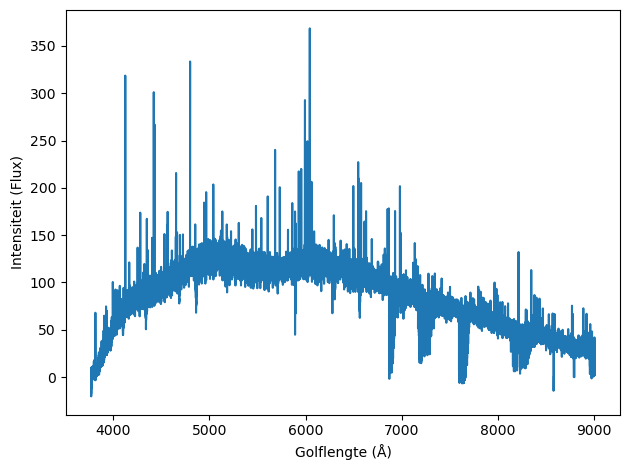

In [120]:
# krijg de data voor datalist[2]
wavelengths, JD, unitx = golflengte_grid(spec, header)
fouts = 300
wavelengths = wavelengths[fouts:]
spec = spec[fouts:]

# grafiek van datalist[2]
fig, ax = plt.subplots()
ax.plot(wavelengths, spec)
ax.set_ylabel("Intensiteit (Flux)")
ax.set_xlabel("Golflengte (Å)")
plt.tight_layout()

plt.show()

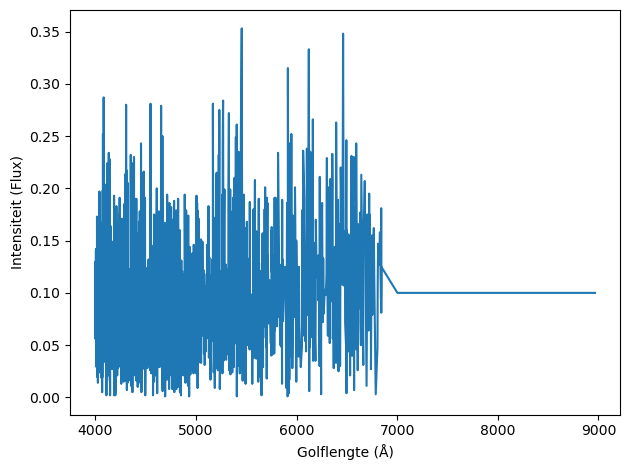

In [121]:
# grafiek van LijnLijst.txt
fig, ax = plt.subplots()
ax.plot(lines, weights)
ax.set_ylabel("Intensiteit (Flux)")
ax.set_xlabel("Golflengte (Å)")
plt.tight_layout()
plt.show()

# **Radiale Snelheid**

In [279]:
# defineer de formules om de radiale snelheid te berekenen
c = const.c
c_kms = c.value * 10**-3

def doppler(v, lambda0):
    return (v*lambda0)/c_kms + lambda0

# probeer verschillende snelheden en neem de kleinst mogelijke error marge op de lambda
def beste_v(wavelength, spec, lines, v_bereik, v_steps):
    # genereer snelheden om te testen
    v_test = np.arange(v_bereik[0], v_bereik[1] + v_steps, v_steps)
    # maak interpolatiefunctie om te snelheden te testen
    interpolate_functie = interpolate.interp1d(wavelength, spec)
    # variabelen voor de fout-kostfunctie
    wavelengthmax, wavelengthmin = wavelength.max(), wavelength.min()
    error_kost = []

    # bereken de fout voor de snelheden
    for v in v_test:
        # bereken de doppler shift
        lambda_shift = doppler(v, lines)
        # filter enkel lijnen binnen de bereik
        binnen_bereik = binnen_bereik = np.logical_and(lambda_shift >= wavelengthmin, lambda_shift <= wavelengthmax)
        lambda_shift = lambda_shift[binnen_bereik]

        # MSE
        if lambda_shift.size > 0:
            flux_observatie = interpolate_functie(lambda_shift)
            fout_mse = np.sqrt(((flux_observatie)**2).mean())
        else:
            fout_mse = np.inf
        error_kost.append(fout_mse)

    # beste snelheid vinden
    error_kost = np.array(error_kost)
    beste_index = np.argmin(error_kost)
    beste_v = v_test[beste_index]
    min_mse = error_kost[beste_index]

    return v_test, beste_v, error_kost

De onzekerheid door verschillende v te proberen en de beste te vinden is veel kleiner dan de systematische fouten: kalibratie, drift, ruis,...
We concluderen dus, dat de onzekerheid bepaald is door systematische fouten en niet door statistische onzekerheid van de doppler en beste_v 

In [287]:
# test de functie op een data
# test = "%s/00307959_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf.fits" %sternaam
test = datalist[36]

test_datalist = glob.glob(test)
test_datalist.sort()
test_spec = pf.getdata(test_datalist[0])
test_header = pf.getheader(test_datalist[0])

test_wl, test_JD, test_unitx = golflengte_grid(test_spec, test_header)

In [303]:
v_t, beste_v_t, error_kost_t = beste_v(test_wl, test_spec, lines, (-10, 17), 0.01)

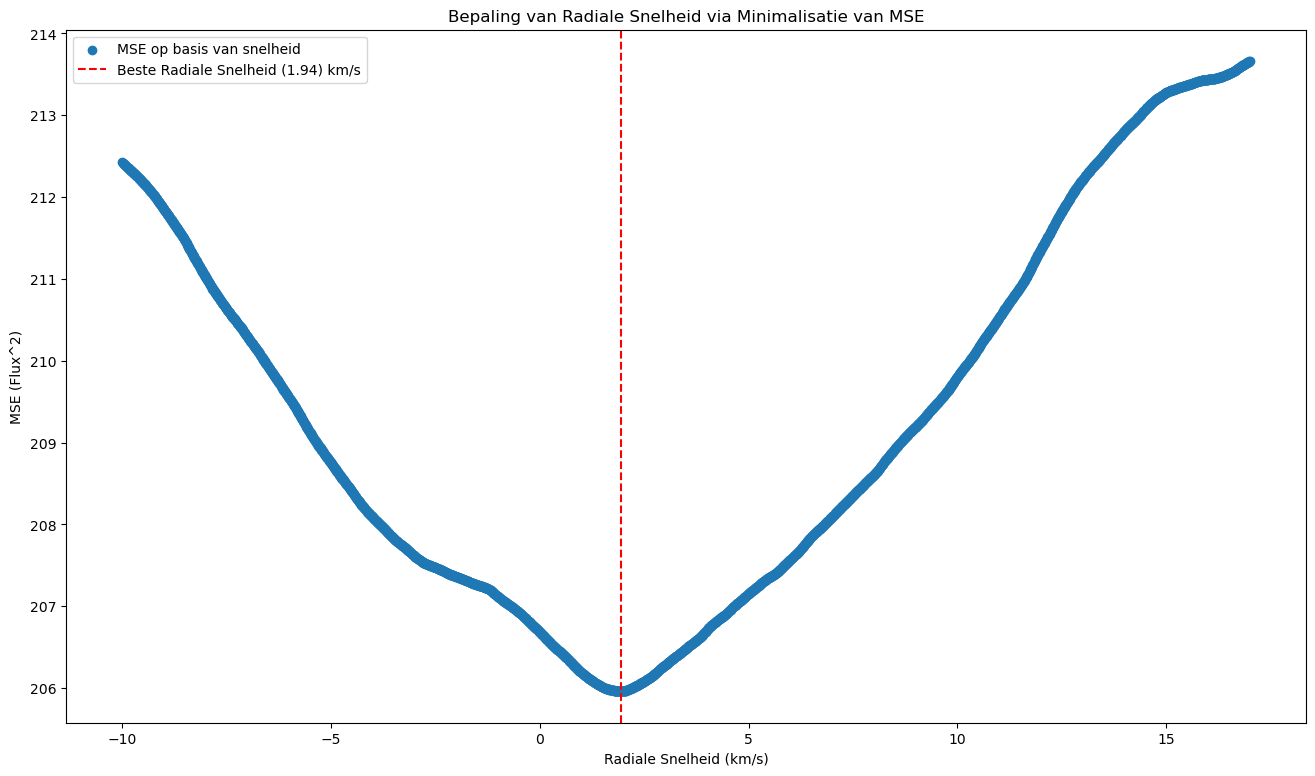

In [304]:
# grafiek van error_kort bepalend van de snelheid
fig, ax = plt.subplots(figsize = (16, 9))
ax.scatter(v_t, error_kost_t, label="MSE op basis van snelheid") # Functie error(v)
plt.axvline(float(beste_v_t), color="red", linestyle="--", label=f"Beste Radiale Snelheid ({beste_v_t:.2f}) km/s")

ax.set_xlabel("Radiale Snelheid (km/s)")
ax.set_ylabel("MSE (Flux^2)")
plt.title("Bepaling van Radiale Snelheid via Minimalisatie van MSE")
plt.legend()
plt.show()

In [305]:
# foutmarge
def radiale_min_fit(x, a, b, c):
    return a*x**2 + b*x + c

def rad(v_t, error_kost_t, marge):
    minimum = np.where(error_kost_t == error_kost_t.min())
    begin = int((minimum[0] - marge)[0])
    einde = int((minimum[0] + marge)[0])

    popt, pcov = curve_fit(radiale_min_fit, v_t[begin:einde], error_kost_t[begin:einde])
    onzekerheid = np.sqrt(np.diag(pcov))

    a, b, c = popt
    nulpunt = -b / (2*a)
    # onzekerheid = sqrt((deltav/deltab * b)**2 + (deltav/deltab * delta a)**2 )
    onzekerheden = np.sqrt((-1/(2*a) * onzekerheid[1])**2 + (b/(2*a**2) * onzekerheid[0])**2)

    return nulpunt, onzekerheden, a, b, c, begin, einde

In [306]:
v_t, beste_v_t, error_kost = beste_v(test_wl, test_spec, lines, (-10, 17), 0.01)

nulpunt, onzekerheden, a, b, c , begin, einde = rad(v_t, error_kost, 5)

In [319]:
print(onzekerheden)

marge = [begin, einde]

0.4923112528904135


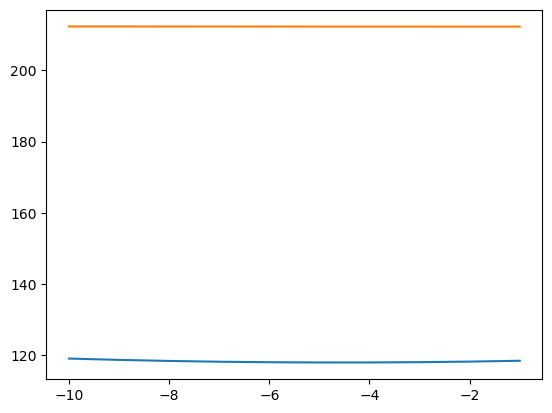

In [321]:

plt.plot(v_t[begin:einde], radiale_min_fit(v_t[begin:einde], a, b, c))
plt.plot(v_t[begin:einde], error_kost_t[begin:einde])

plt.show()

In [311]:
# bepaal radiale snelheid voor alle gekregen data van BD-11_162
snelheid = []
gecorrigeerde_snelheid = [] # Afhankelijk waar de aarde was, verschilt de gemeten snelheid
tijd = []
onzekerheid_v = []
nulpunten = []

# itereer over alle data
for data in datalist:
    spec = pf.getdata(data)
    header = pf.getheader(data)

    # bereken alle waarder
    wavelengths, JD, unitx = golflengte_grid(spec, header)
    # beste_snelheid = beste_v(wavelengths, spec, lines, (-30, 30), 0.1)[1] # functie returnt 3 waardes en hebben de 2de nodig
    v_t, beste_v_t, error_kost = beste_v(wavelengths, spec, lines, (-10, 17), 0.01)
    # krijg de correctie van snelheid (zie header; BVCOR)
    # correctie_v = header['BVCOR']
    # zet de snelheden en tijden in lijsten'
    snelheid.append(beste_v_t)
    # gecorrigeerde_snelheid.append(beste_v_t)
    nulpunt, onzekerheden, a, b, c, begin, einde= rad(v_t, error_kost, 5)
    onzekerheid_v.append(onzekerheden)
    gecorrigeerde_snelheid.append(nulpunt)
    tijd.append(JD)

In [318]:
# bepaal radiale snelheid voor alle gekregen data van BD-11_162
snelheid = []
gecorrigeerde_snelheid = [] # Afhankelijk waar de aarde was, verschilt de gemeten snelheid
tijd = []
onzekerheid_v = []
nulpunten = []

for data in datalist:
    spec = pf.getdata(data)
    header = pf.getheader(data)

    # bereken alle waarder
    wavelengths, JD, unitx = golflengte_grid(spec, header)
    # beste_snelheid = beste_v(wavelengths, spec, lines, (-30, 30), 0.1)[1] # functie returnt 3 waardes en hebben de 2de nodig
    v_t, beste_v_t, error_kost = beste_v(wavelengths, spec, lines, (-30, 30), 1)
    # krijg de correctie van snelheid (zie header; BVCOR)
    # correctie_v = header['BVCOR']
    # zet de snelheden en tijden in lijsten'
    snelheid.append(beste_v_t)
    # gecorrigeerde_snelheid.append(beste_v_t)
    nulpunt, onzekerheden, a, b, c, begin, einde= rad(v_t, error_kost, 5)
    onzekerheid_v.append(onzekerheden)
    gecorrigeerde_snelheid.append(nulpunt)
    tijd.append(JD)

print(min(snelheid))

-7


In [312]:
# conversie van Juliaanse tijd
t = Time(tijd, format="jd", scale='tdb')
datum = t.to_datetime()

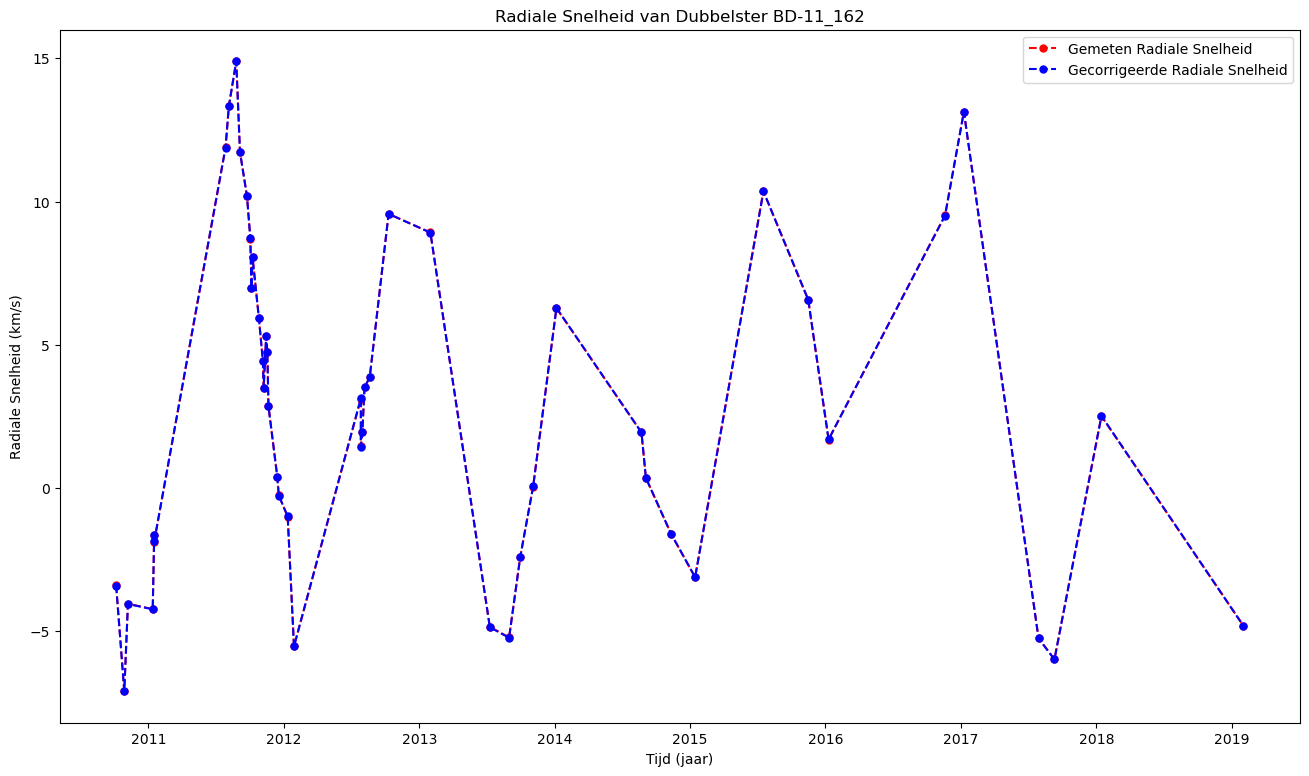

In [313]:
# plot Radiale Snelheid door de tijd heen
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(datum, snelheid, 'o--', color='red', markersize=5, label='Gemeten Radiale Snelheid')
ax.plot(datum, gecorrigeerde_snelheid, 'o--', color='blue', markersize=5, label='Gecorrigeerde Radiale Snelheid')

ax.set_xlabel("Tijd (jaar)")
ax.set_ylabel("Radiale Snelheid (km/s)")
plt.title(f'Radiale Snelheid van Dubbelster {sternaam}')
plt.legend()
plt.show()

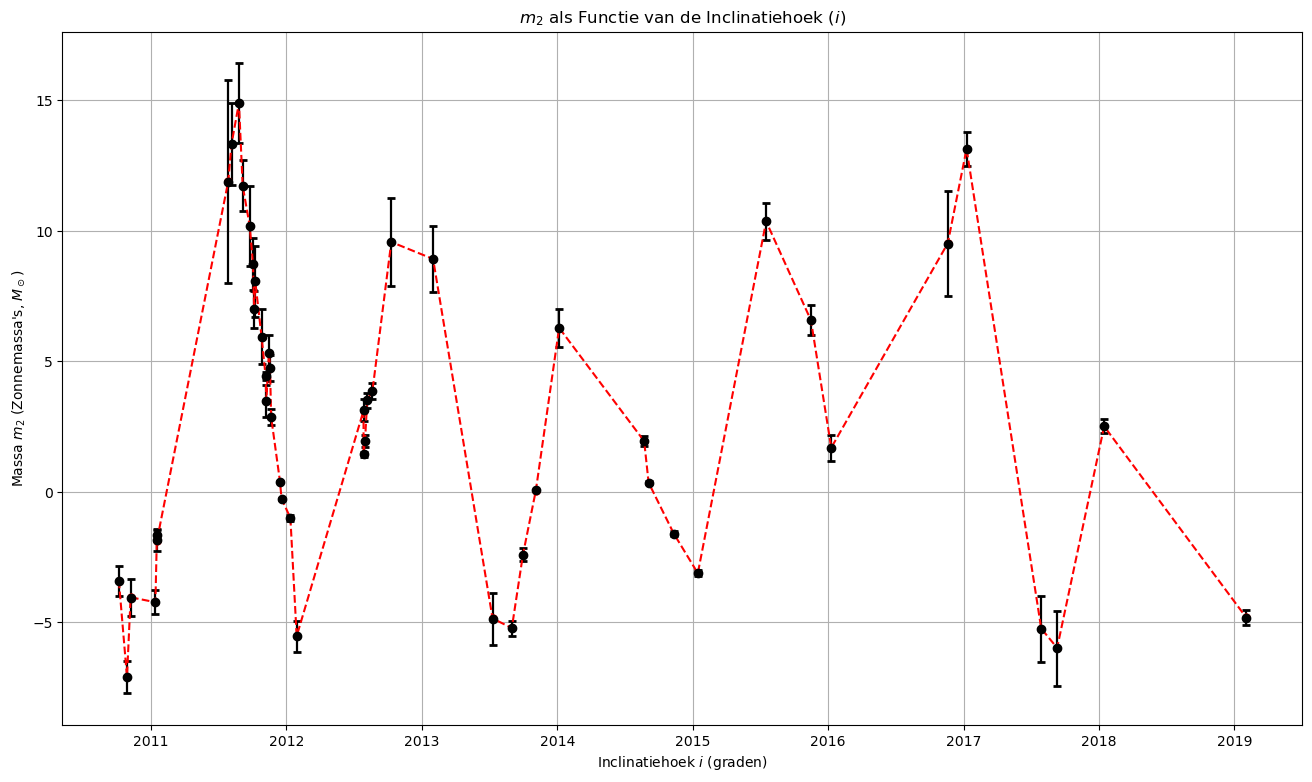

In [314]:
# maak grafiek
fig, ax = plt.subplots(figsize = (16, 9))

# Plot de data met errorbars
ax.errorbar(
    np.array(datum).flatten(),
    np.array(gecorrigeerde_snelheid).flatten(),
    yerr=np.array(onzekerheid_v).flatten(),
    linestyle='',
    color='black',
    ecolor='black',
    marker="o",
    markersize=6,
    capsize=3,
    capthick=2,
    linewidth=1.6,
)
ax.plot(datum, snelheid, 'o--', color='red', markersize=5, label='Gemeten Radiale Snelheid')

# plot stippenlijn door de data
# ax.plot(inclinatie_graden_benadering, m2_benadering, color='red', linestyle='--')



plt.title('$m_2$ als Functie van de Inclinatiehoek ($i$)')
ax.set_xlabel('Inclinatiehoek $i$ (graden)')
ax.set_ylabel('Massa $m_2$ (Zonnemassa\'s, $M_\\odot$)')

plt.grid(True)
plt.show()

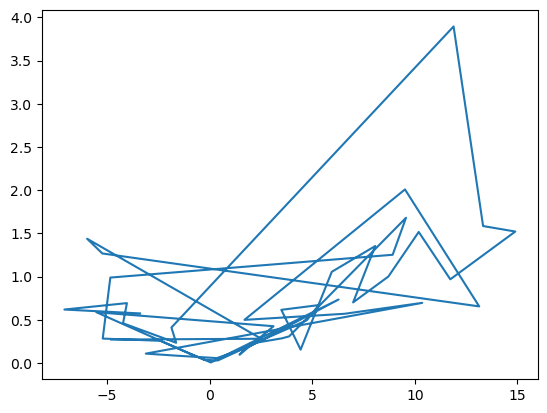

np.float64(0.6989265691525038)

In [315]:
plt.plot(snelheid, onzekerheid_v)
plt.show()

a = sum(onzekerheid_v) / (len(onzekerheid_v))
a

### *Periode, Amplitude en massa voor gecorrigeerde snelheden*

In [170]:
# Bereken periode
t = np.array(tijd)
v = np.array(gecorrigeerde_snelheid)
# test periodes tussen 0.5 en 1000 dagen
frequenties = np.linspace(1/10000000.0, 1/0.5, 100000)

# bereken het periode-gram
power = LombScargle(t, v).power(frequenties)
# neem de beste frequentie (hoogste piek)
beste_freq = frequenties[np.argmax(power)]
# periode = 1/freq
P_dagen = 1.0/beste_freq
sigma_P_dagen = LombScargle(t, v).false_alarm_probability(np.max(power)) # niet zeker, online gevonden
print(f"Berekende Periode (P): {P_dagen:.4f} dagen") # zie juist onder, onzekerheid is kleiner dan 10**-20
# print(f"Berekende Periode (P): {P_dagen:.4f} +/- {sigma_P_dagen:.23f} dagen")

Berekende Periode (P): 499.9700 dagen


In [171]:
# model voor fit functie
def radiale_snelheid_fit(tijd, amplitude, t0, b, P):
    # v(t) = A*sin(2pi/P * (t-t0)) + b
    # P = P_dagen
    return amplitude * np.sin((2*np.pi / P) * (tijd - t0)) + b

amplitude_gok = (v.max() - v.min())/2
b_gok = np.median(v)
t0_gok = t[np.argmin(v)] # Datum van het minimum

In [172]:
# calculatie
popt, pcov = curve_fit(radiale_snelheid_fit, t, v, p0=[amplitude_gok, t0_gok, b_gok, P_dagen])
onzekerheid = np.sqrt(np.diag(pcov))

In [173]:
# Bekijk de fit
amplitude, t0, b, P_fit = popt
sigma_A, sigma_t0, sigma_b, sigma_P_fit = onzekerheid

print(f"Amplitude (A): {amplitude:.4f} +/- {sigma_A:.4f} km/s")
print(f"t0: {t0:.4f} +/- {sigma_t0:0.4f} k")
print(f"Systemische Snelheid (b): {b:.4f} +/- {sigma_b:.4f} km/s")
print(f"Periode (dagen): {P_fit:.4f} +/- {sigma_P_fit:.4f} dagen")

Amplitude (A): 8.6762 +/- 0.2800 km/s
t0: 2455142.6908 +/- 4.8256 k
Systemische Snelheid (b): 3.2173 +/- 0.1891 km/s
Periode (dagen): 498.1131 +/- 1.7814 dagen


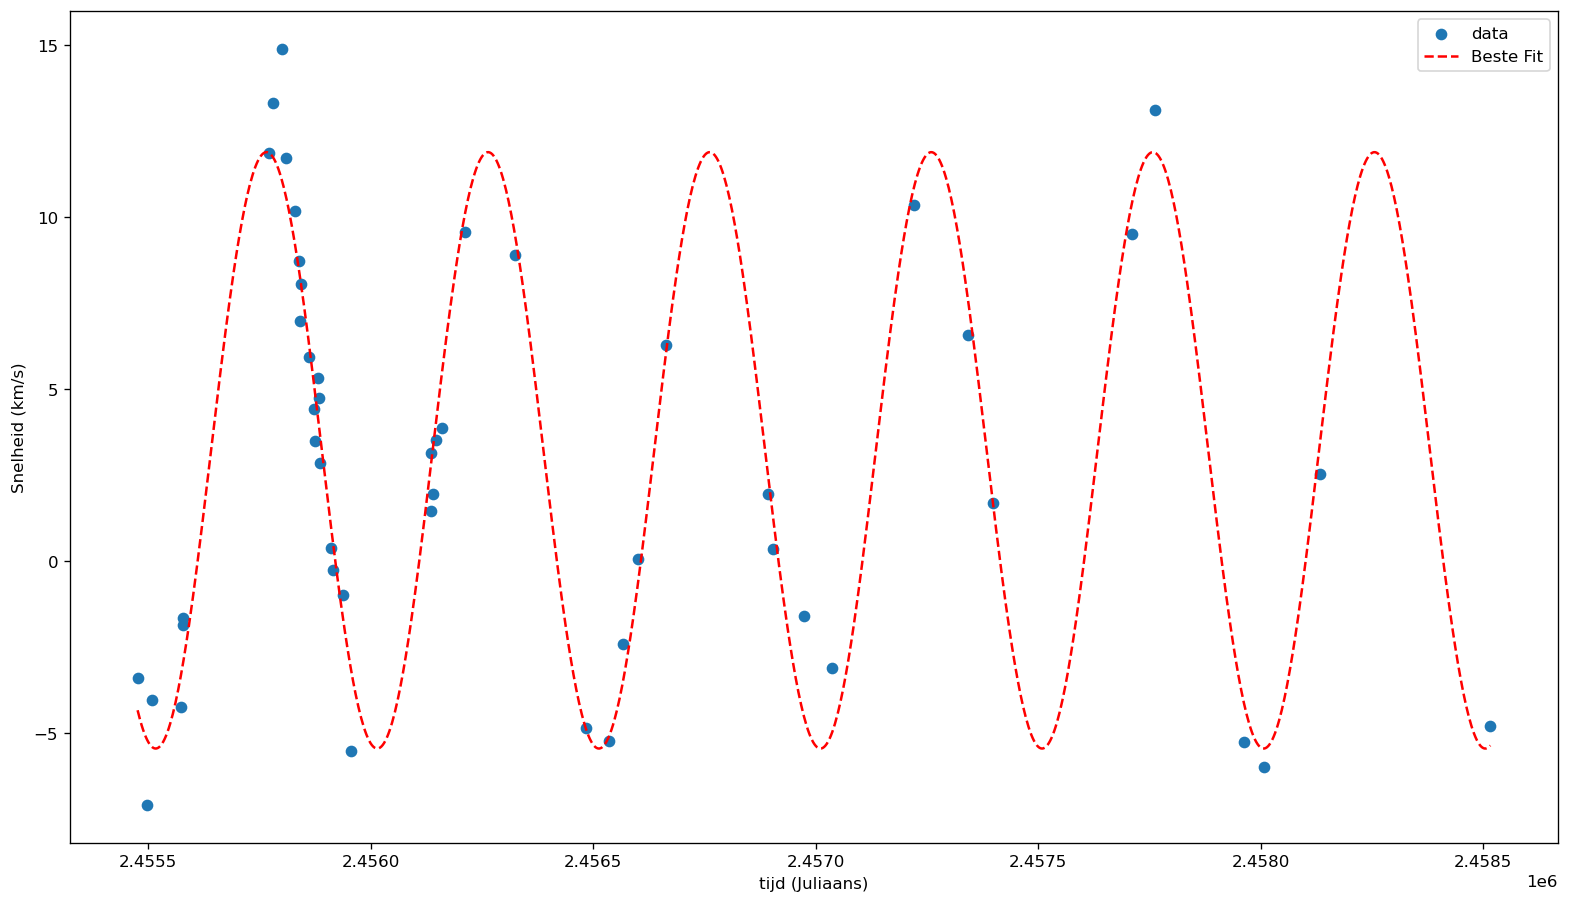

In [174]:
# grafiek van schatting
fig, ax = plt.subplots(dpi=120, figsize=(16, 9))

t_fit = np.linspace(t.min(), t.max(), 1000)
ax.scatter(t, v, label="data")
ax.plot(t_fit,
        radiale_snelheid_fit(t_fit, amplitude, t0, b, P_fit),
        label="Beste Fit",
        color = 'red',
        linestyle='--')

ax.set_ylabel("Snelheid (km/s)")
ax.set_xlabel("tijd (Juliaans)")
plt.legend()
plt.show()

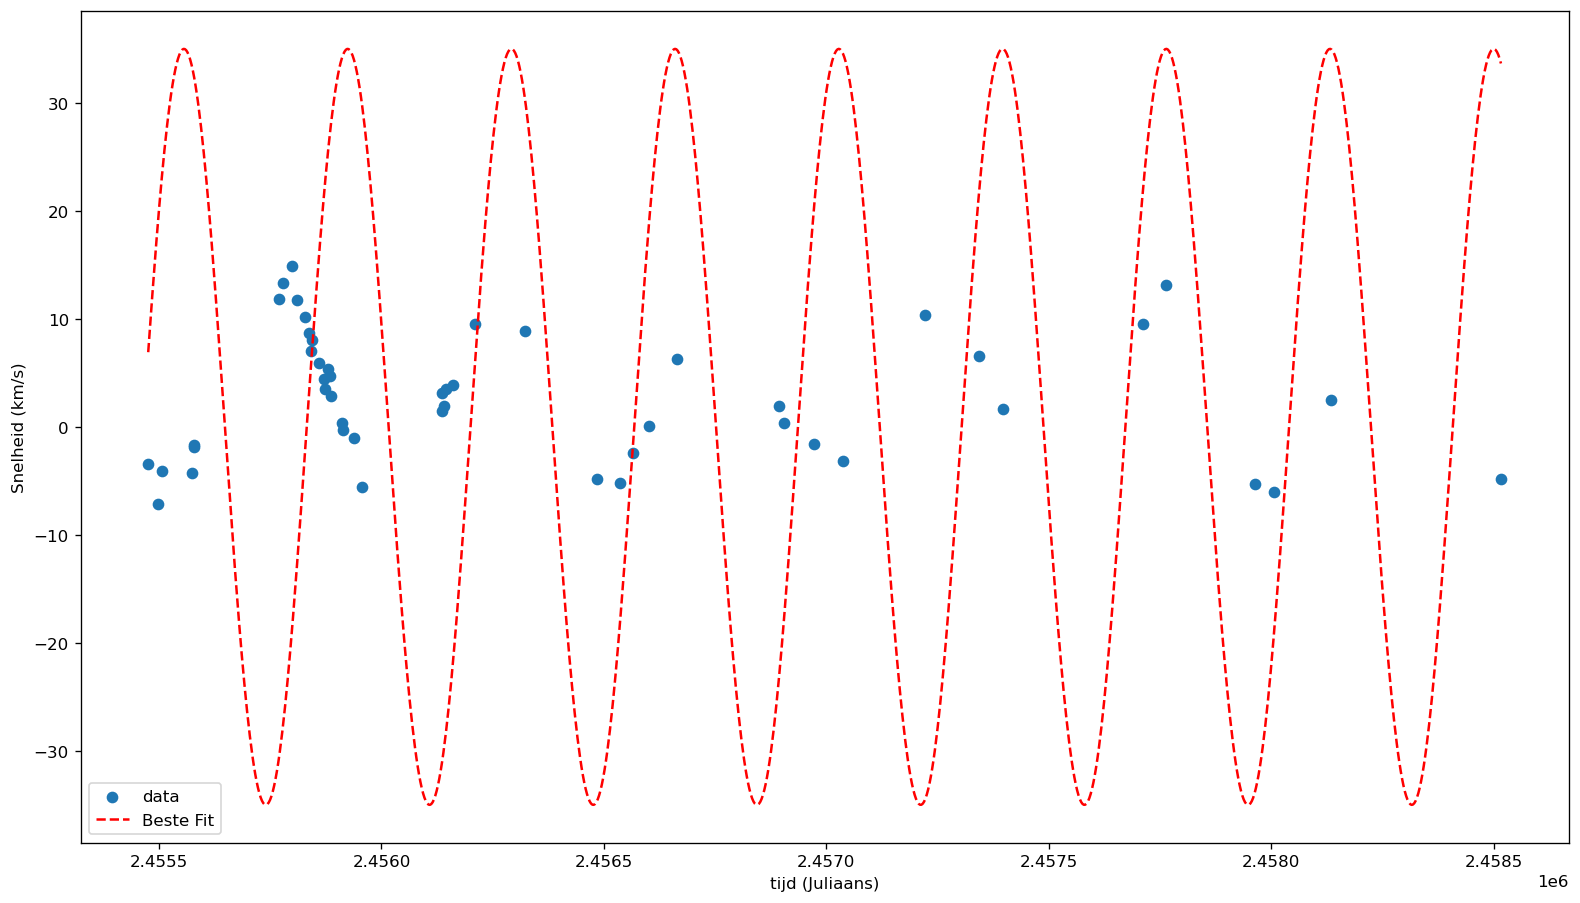

In [175]:
# grafiek van zelf schatting om de popt en pocv beter te schatten
fig, ax = plt.subplots(dpi=120, figsize=(16, 9))

t_fit = np.linspace(t.min(), t.max(), 1000)
ax.scatter(t, v, label="data")
ax.plot(t_fit,
        radiale_snelheid_fit(t_fit, 35, -200, 0, 368),
        label="Beste Fit",
        color = 'red',
        linestyle='--')

ax.set_ylabel("Snelheid (km/s)")
ax.set_xlabel("tijd (Juliaans)")
plt.legend()
plt.show()

### *Periode, Amplitude en massa voor niet gecorrigeerde snelheid*
ng = niet gecorrigeerd

In [176]:
# Bereken periode
t_ng = np.array(tijd)
v_ng = np.array(snelheid)
# test periodes tussen 0.5 en 1000 dagen
frequenties_ng = np.linspace(1/10000.0, 1, 100000)

# bereken het periode-gram
power_ng = LombScargle(t_ng, v_ng).power(frequenties_ng)
# neem de beste frequentie (hoogste piek)
beste_freq_ng = frequenties_ng[np.argmax(power_ng)]
# periode = 1/freq
P_dagen_ng = 1.0/beste_freq_ng
sigma_P_dagen_ng = LombScargle(t_ng, v_ng).false_alarm_probability(np.max(power_ng)) # niet zeker, online gevonden
print(f"Berekende Periode (P): {P_dagen_ng:.4f} dagen") # zie juist onder, onzekerheid is kleiner dan 10**-20
# print(f"Berekende Periode (P): {P_dagen_ng:.4f} +/- {sigma_P_dagen_ng:.28f} dagen")

Berekende Periode (P): 497.5550 dagen


In [177]:
amplitude_ng_gok = (v_ng.max() - v_ng.min())/2
b_ng_gok = np.median(v_ng)
t0_ng_gok = t_ng[np.argmin(v_ng)] # Datum van het minimum

In [178]:
# calculatie
popt_ng, pcov_ng = curve_fit(radiale_snelheid_fit, t_ng, v_ng, p0=[amplitude_ng_gok, t0_ng_gok, b_ng_gok, P_dagen_ng])
onzekerheid_ng = np.sqrt(np.diag(pcov_ng))

In [179]:
# Bekijk de fit
amplitude_ng, t0_ng, b_ng, P_dagen_ng_fit = popt_ng
sigma_ng_A, sigma_ng_t0, sigma_ng_b, sigma_P_dagen_ng_fit = onzekerheid_ng

print(f"Amplitude (A_ng): {amplitude_ng:.4f} +/- {sigma_ng_A:.4f} km/s")
# print(f"t0: {t0_ng:.4f} +/- {sigma_ng_t0:0.4f} k")
print(f"Systemische Snelheid (b_ng): {b_ng:.4f} +/- {sigma_ng_b:.4f} km/s")
print(f"Periode (dagen): {P_dagen_ng_fit:.4f} +/- {sigma_P_dagen_ng_fit:.4f} dagen")

Amplitude (A_ng): 8.6755 +/- 0.2797 km/s
Systemische Snelheid (b_ng): 3.2199 +/- 0.1890 km/s
Periode (dagen): 498.1216 +/- 1.7798 dagen


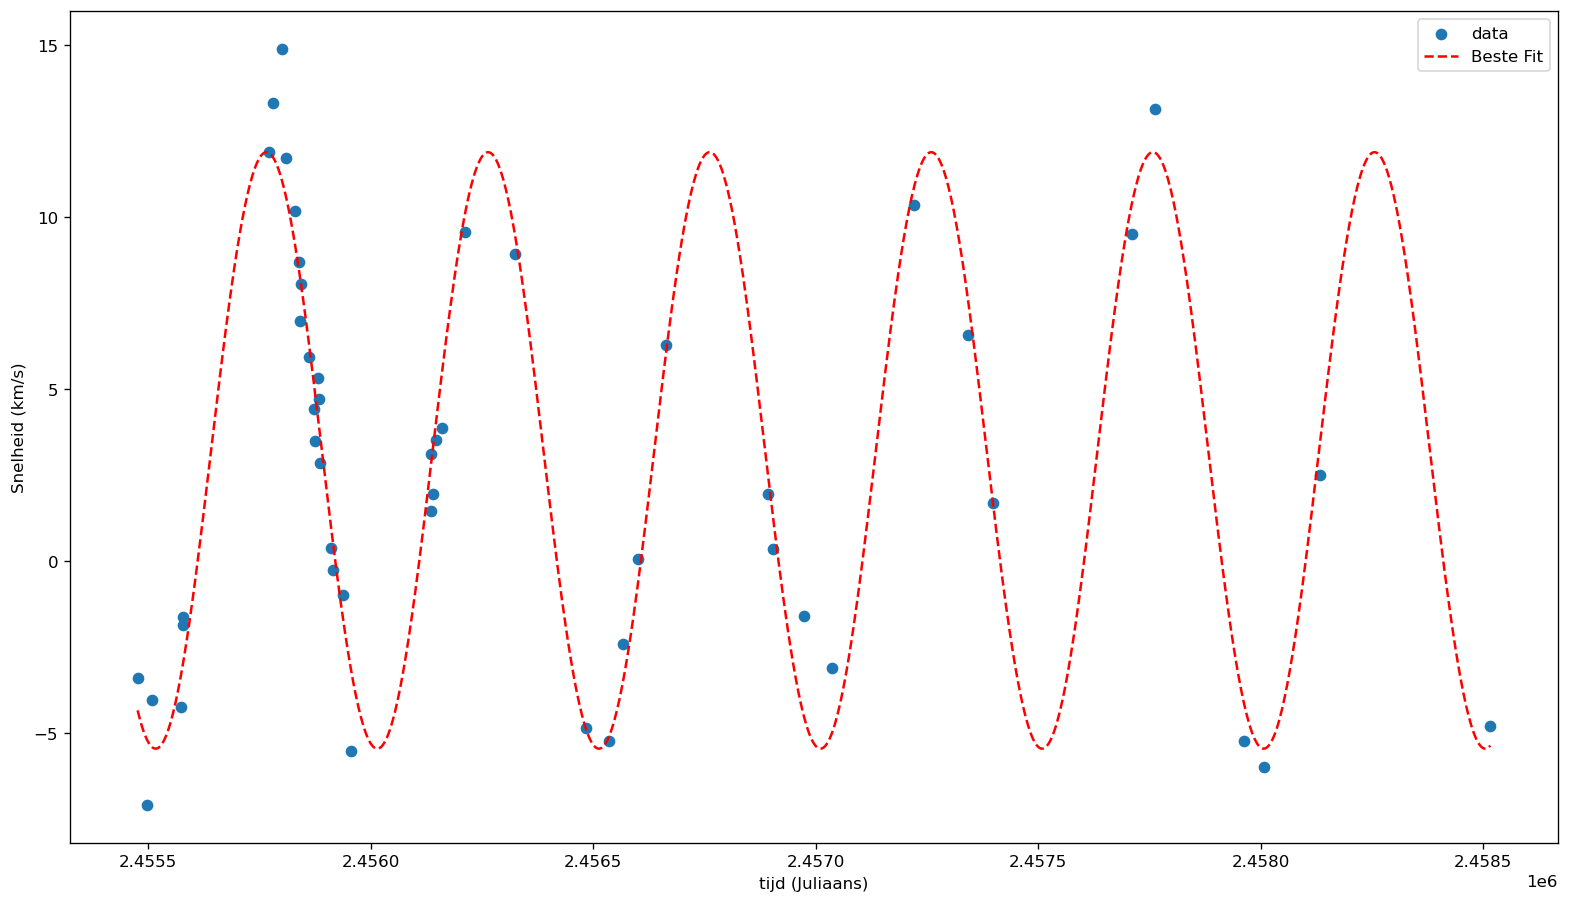

In [180]:
# grafiek van schatting
fig, ax = plt.subplots(dpi=120, figsize=(16, 9))

t_ng_fit = np.linspace(t_ng.min(), t_ng.max(), 1000)
ax.scatter(t_ng, v_ng, label="data")
ax.plot(t_ng_fit,
        radiale_snelheid_fit(t_ng_fit, amplitude_ng, t0_ng, b_ng, P_dagen_ng_fit),
        label="Beste Fit",
        color = 'red',
        linestyle='--')

ax.set_ylabel("Snelheid (km/s)")
ax.set_xlabel("tijd (Juliaans)")
plt.legend()
plt.show()

# **Massa bepaling**
### *Voor gecorrigeerde snelheid*

In [181]:
G = const.G.value
m_zon_kg = const.M_sun.value

# verander naar SI-eenheden
P_seconden = P_dagen * 60 * 60 * 24 # 60s * 60min * 24u = dag
sigma_P_seconden = sigma_P_dagen * 60 * 60 * 24
A_ms = amplitude * 10**3
sigma_A_ms = sigma_A * 10**3
m1_kg = 0.6 * m_zon_kg
sigma_m1_kg = 0.1 * m_zon_kg

# functies voor berekeningen
def massa_functie(periode_sec, K_ms):
    return (periode_sec / (2 * np.pi)) * (K_ms**3)

def onzekerheid_massa_functie(A_ms, simga_A_ms, P_sec, sigma_P_sec):
    # sigma_f(M)^2 = (v**3/2piG * sigmaP)^2 + (3pi v**2 / 2piG * sigmav)^2
    onzekerheid_f_M = ((A_ms**3 * sigma_P_sec) / (2*np.pi*G))**2 + ((3*P_sec*A_ms**2 *sigma_A_ms) / (2*np.pi*G))**2
    sigma_f_M = np.sqrt(onzekerheid_f_M)
    sigma_f_M_zonnemassa = sigma_f_M / m_zon_kg
    return sigma_f_M, sigma_f_M_zonnemassa


def nulwaarden(a, b, c, d):
    wortels = np.roots([a, b, c, d])
    reele_wortels = wortels[np.isreal(wortels)].real
    return reele_wortels

def massa2(f_M_overG, m1, hoek):
    # f(M)/sin(i)**3 = m2**3 / (m1 + m2)**2
    # neem f(m)/sini**3 als B en m1 als A
    # x**3 - Bx**2 - 2ABx - A**2B ; met x = m2
    sin_i = np.sin(hoek)
    B = f_M_overG / (sin_i**3)
    A = m1
    a = 1.0; b = -B; c = -2*A*B; d = -(A**2) * B
    return nulwaarden(a, b, c, d)

def onzekerheid_m2(m2_kg, m1_kg, inclinatie, sigma_f_M):
    # zet hoek van graden naar radialen
    inclinatie = np.deg2rad(inclinatie)
    sin_i = np.sin(inclinatie)
    
    # we doen partiele afgeleiden van delta_m2/delta_f(m) over f(m) = sin**3 m2**3/(m1+m2)**2
    # voor partiele afgeleide van delta_m2/delta_hoek, delta hoek is ongeveer 0
    # we krijgen dus voor delta_m2/delta_f(m) => 1 = m2' * (sin**3 3*m_2**2 - 2(m1+m2)* sin**3 m2**3)/ (m1+m2)**4
    # we zetten m_2' apart en krijgen we m_2' = (m1+m2)**4 / (3 m2**2 sin**3 - (2(m1+m2) sin**3 m_2**3))
    teller = (m1_kg + m2_kg)**4
    noemer_1 = 3*m2_kg**2*sin_i**3
    noemer_2 = 2*(m1_kg + m2_kg) * sin_i**3 * m2_kg**3
    noemer = noemer_1 - noemer_2
    # we nemen geen kwadraat of wortel want we hebben maar 1 onzekerheid nl. f(m)
    
    sigma_m2 = (teller / noemer) * sigma_f_M
    sigma_m2_zonnemassa = sigma_m2 / m_zon_kg

    return abs(sigma_m2), abs(sigma_m2_zonnemassa)

In [182]:
# berekeningen f(M)
f_M = massa_functie(P_seconden, A_ms)
f_M_overG = f_M / G
f_M_zonnemassa = f_M_overG / m_zon_kg

# onzekerheid f(M) bij 90graden
sigma_f_M_kg, sigma_f_M_zonnemassa = onzekerheid_massa_functie(A_ms, sigma_A_ms, P_seconden, sigma_P_seconden)

# minimum massa m2 (bij i = 90 graden)
i_min_rad = np.deg2rad(75.0)
m2_min_kg = massa2(f_M_overG, m1_kg, i_min_rad)
m2_min_zonnemassa = m2_min_kg / m_zon_kg

# onzekerheid voor minimum massa m2
sigma_m2_min_kg, sigma_m2_min_zonnemassa = onzekerheid_m2(m2_min_kg, m1_kg, 90, sigma_f_M_kg)

print(f"Massafunctie f(M): {f_M_zonnemassa:.4f} ± {sigma_f_M_zonnemassa:.4f} M_zon")
print(f"Minimum m_2 (M_zon): {float(m2_min_zonnemassa[0]):.4f} ± {float(sigma_m2_min_zonnemassa[0]):.4f} M_zon")

Massafunctie f(M): 0.0338 ± 0.0033 M_zon
Minimum m_2 (M_zon): 0.3158 ± 0.0399 M_zon


In [183]:
# Grafiek maken m2 per inclinatie
m2_zonnemassa_lijst = []
sigma_m2_zonnemassa_lijst = []
m2_benadering = []
sigma_m2_benadering = []

# hoeken generen voor grafiek
inclinatie_graden_benadering = np.linspace(10, 90, 50) # kan niet delen door 0, dus begin altijd > 0
inclinatie_graden = [10, 20, 40, 70, 90]
inclinatie_rad = np.deg2rad(inclinatie_graden)
inclinatie_rad_benadering = np.deg2rad(inclinatie_graden_benadering)

# massa's berekenen
for hoek in inclinatie_rad:
    # bereken massa
    massa2_h = massa2(f_M_overG, m1_kg, hoek)
    m2_zonnemassa_lijst.append(massa2_h / m_zon_kg)
    # bereken onzekerheid
    simga_m2_inc, sigma_m2_zonnemassa_inc = onzekerheid_m2(massa2_h, m1_kg, np.rad2deg(hoek), sigma_f_M_kg)
    sigma_m2_zonnemassa_lijst.append((sigma_m2_zonnemassa_inc))

for hoek in inclinatie_rad_benadering:
    massa2_h = massa2(f_M_overG, m1_kg, hoek)
    m2_benadering.append(massa2_h / m_zon_kg)
    

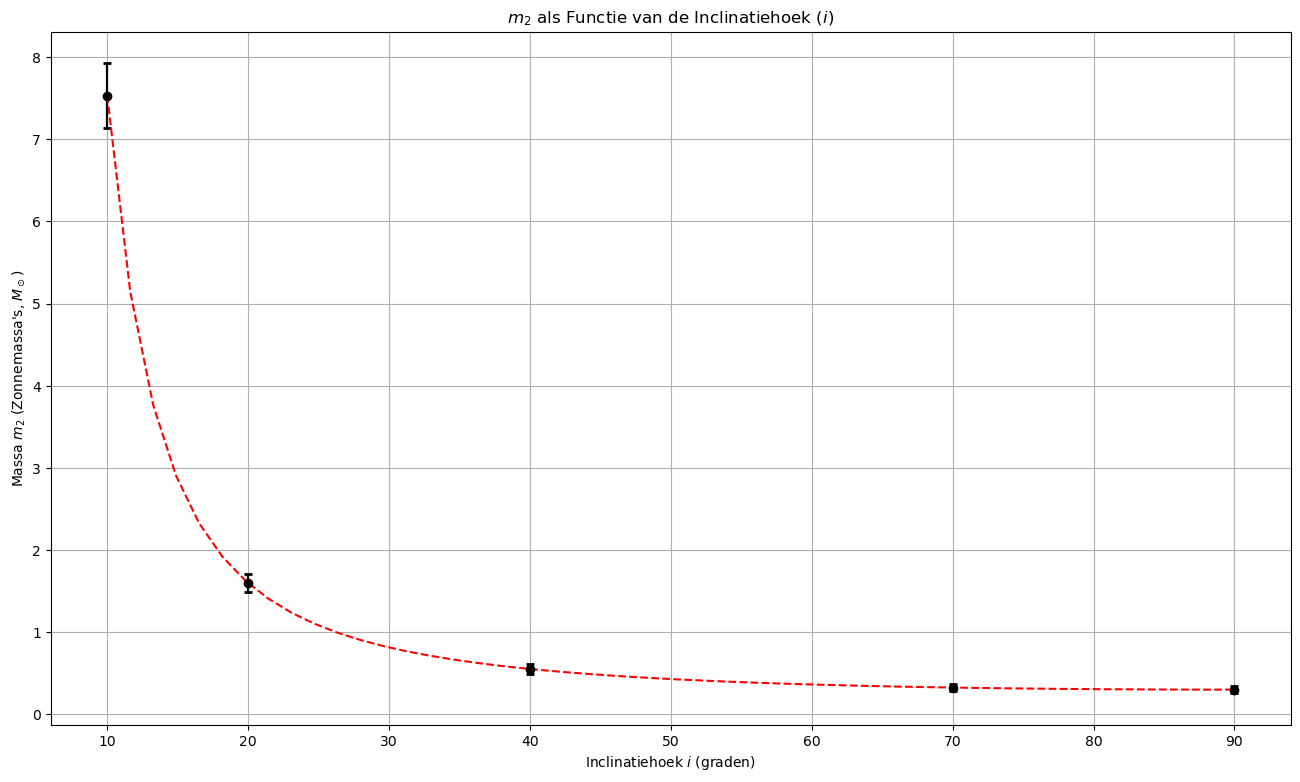

In [194]:
# maak grafiek
fig, ax = plt.subplots(figsize = (16, 9))

# Plot de data met errorbars
ax.errorbar(
    np.array(inclinatie_graden).flatten(),
    np.array(m2_zonnemassa_lijst).flatten(),
    yerr=np.array(sigma_m2_zonnemassa_lijst).flatten(),
    linestyle='',
    color='black',
    ecolor='black',
    marker="o",
    markersize=6,
    capsize=3,
    capthick=2,
    linewidth=1.6,
)

# plot stippenlijn door de data
ax.plot(inclinatie_graden_benadering, m2_benadering, color='red', linestyle='--')



plt.title('$m_2$ als Functie van de Inclinatiehoek ($i$)')
ax.set_xlabel('Inclinatiehoek $i$ (graden)')
ax.set_ylabel('Massa $m_2$ (Zonnemassa\'s, $M_\\odot$)')

plt.grid(True)
plt.show()

# **Massa Bepaling**
### *voor niet gecorrigeerde snelheid*

In [102]:
# verander naar SI-eenheden
P_seconden_ng = P_dagen_ng * 60 * 60 * 24 # 60s * 60min * 24u = dag
sigma_P_seconden_ng = sigma_P_dagen_ng * 60 * 60 * 24
A_ms_ng = amplitude_ng * 10**3
sigma_A_ms_ng = sigma_ng_A * 10**3
m1_kg = 0.6 * m_zon_kg
sigma_m1_kg = 0.1 * m_zon_kg

In [103]:
# berekeningen f(M); de functies veranderen niet voor gecorrigeerde of niet snelheid
f_M_ng = massa_functie(P_seconden_ng, A_ms_ng)
f_M_overG_ng = f_M_ng / G
f_M_zonnemassa_ng = f_M_overG_ng / m_zon_kg

# onzekerheid f(M) bij 90graden
sigma_f_M_kg_ng, sigma_f_M_zonnemassa_ng = onzekerheid_massa_functie(A_ms_ng, sigma_A_ms_ng, P_seconden_ng, sigma_P_seconden_ng)

# minimum massa m2 (bij i = 90 graden)
m2_min_kg_ng = massa2(f_M_overG_ng, m1_kg, i_min_rad)
m2_min_zonnemassa_ng = m2_min_kg_ng / m_zon_kg

# onzekerheid voor minimum massa m2
sigma_m2_min_kg_ng, sigma_m2_min_zonnemassa_ng = onzekerheid_m2(m2_min_kg_ng, m1_kg, 90, sigma_f_M_kg_ng)

print(f"Massafunctie f(M): {f_M_zonnemassa_ng:.4f} ± {sigma_f_M_zonnemassa_ng:.4f} M_zon")
print(f"Minimum m_2 (M_zon): {float(m2_min_zonnemassa_ng[0]):.4f} ± {float(sigma_m2_min_zonnemassa_ng[0]):.4f} M_zon")

Massafunctie f(M): 0.0337 ± 0.0211 M_zon
Minimum m_2 (M_zon): 0.3015 ± 0.2815 M_zon


In [104]:
# Grafiek maken m2 per inclinatie
m2_zonnemassa_lijst_ng = []
sigma_m2_zonnemassa_lijst_ng = []
m2_ng_ben = []

# hoeken generen voor grafiek
inclinatie_graden_ng_ben = np.linspace(10, 90, 50) # kan niet delen door 0, dus begin altijd > 0
inclinatie_graden_ng = [10, 20, 40, 70, 90]
inclinatie_rad_ng = np.deg2rad(inclinatie_graden_ng)
inclinatie_rad_ng_ben = np.deg2rad(inclinatie_graden_ng_ben)

# massa's berekenen
for hoek in inclinatie_rad_ng:
    # bereken massa
    massa2_h_ng = massa2(f_M_overG_ng, m1_kg, hoek)
    m2_zonnemassa_lijst_ng.append(massa2_h_ng / m_zon_kg)
    # bereken onzekerheid
    simga_m2_inc_ng, sigma_m2_zonnemassa_inc_ng = onzekerheid_m2(massa2_h_ng, m1_kg, np.rad2deg(hoek), sigma_f_M_kg_ng)
    sigma_m2_zonnemassa_lijst_ng.append((sigma_m2_zonnemassa_inc_ng))

for hoek in inclinatie_rad_ng_ben:
    massa2_h_ng = massa2(f_M_overG_ng, m1_kg, hoek)
    m2_ng_ben.append(massa2_h_ng / m_zon_kg)

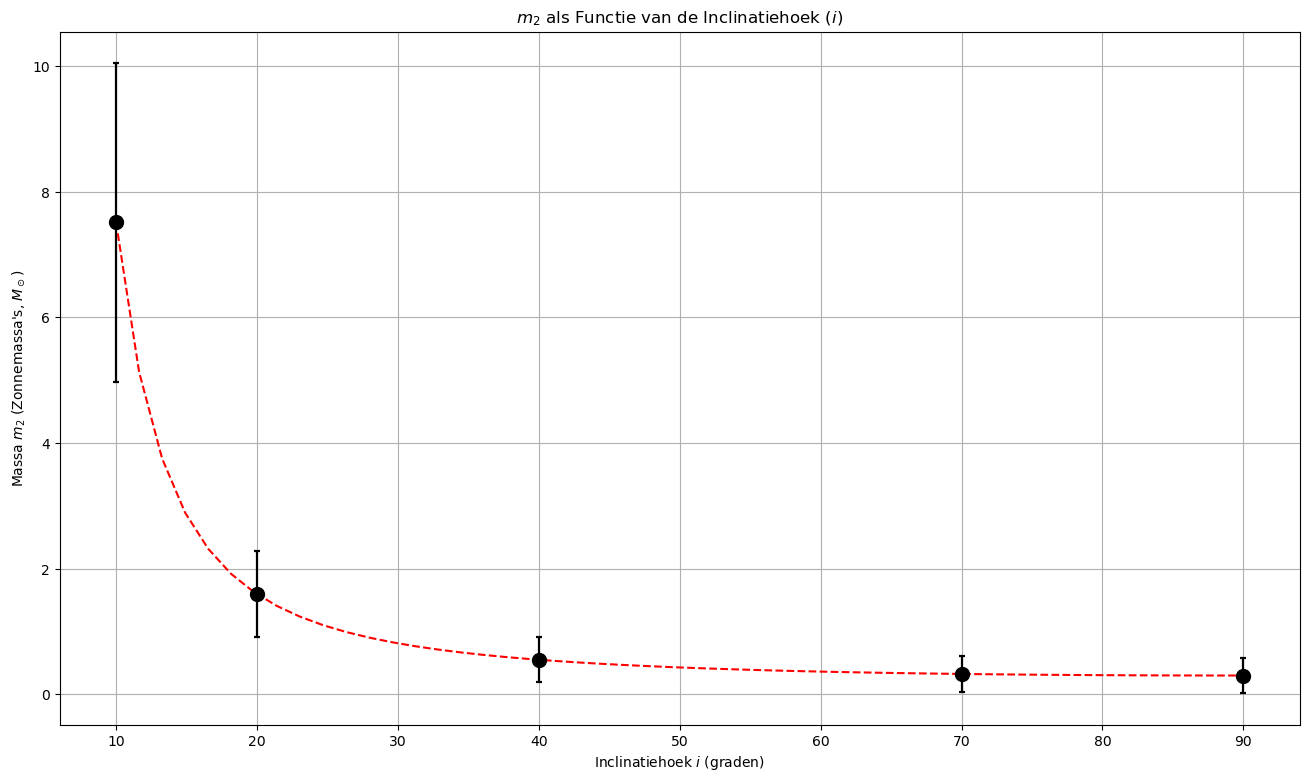

In [105]:
# maak grafiek
fig, ax = plt.subplots(figsize = (16, 9))

# Plot de data met errorbars
ax.errorbar(
    np.array(inclinatie_graden_ng).flatten(),
    np.array(m2_zonnemassa_lijst_ng).flatten(),
    yerr=np.array(sigma_m2_zonnemassa_lijst_ng).flatten(),
    linestyle='',
    color='black',
    ecolor='black',
    marker="o",
    markersize=10,
    capsize=2,
    capthick=1.6,
    linewidth=1.6,
)

# plot stippenlijn door de data
ax.plot(inclinatie_graden_ng_ben, m2_ng_ben, color='red', linestyle='--')



plt.title('$m_2$ als Functie van de Inclinatiehoek ($i$)')
ax.set_xlabel('Inclinatiehoek $i$ (graden)')
ax.set_ylabel('Massa $m_2$ (Zonnemassa\'s, $M_\\odot$)')

plt.grid(True)
plt.show()

In [323]:
import numpy as np
from astropy import constants as const

# 1. Constanten en Input Waarden
# -----------------------------
G = const.G.value
m_zon_kg = const.M_sun.value

# Aanname voor de hoofdcomponent (Witte Dwerg)
m1_kg = 0.6 * m_zon_kg 

# Waarden uit de fit (voorbeeldwaarden die leiden tot jouw resultaat)
# P = Periode in dagen, K = Amplitude in km/s
P_dag = 498.08       # Periode
delta_P_dag = 1.78   # Onzekerheid op Periode
K_kms = 8.67         # Amplitude radiale snelheid
delta_K_kms = 0.28   # Onzekerheid op Amplitude

# 2. Hulpfuncties voor Conversie en Berekening
# --------------------------------------------
def naarSI(P, delta_P, K, delta_K):
    """Zet eenheden om naar SI (seconden en m/s)"""
    P_sec = P * 24 * 3600 
    delta_P_sec = delta_P * 24 * 3600
    K_ms = K * 1000
    delta_K_ms = delta_K * 1000
    return P_sec, delta_P_sec, K_ms, delta_K_ms

def massa_functie(P_sec, K_ms):
    """Berekent f(M) in kg"""
    return (P_sec / (2 * np.pi)) * (K_ms**3) / G

def onzekerheid_massa_functie(K_ms, sigma_K_ms, P_sec, sigma_P_sec):
    """
    Berekent de onzekerheid op f(M) via foutpropagatie.
    f(M) ~ P * K^3
    sigma_f = f * sqrt( (sigma_P/P)^2 + (3*sigma_K/K)^2 )
    """
    f_m = massa_functie(P_sec, K_ms)
    
    # Relatieve fouten optellen in kwadratuur (met machtsfactor 3 voor K)
    rel_err_P = sigma_P_sec / P_sec
    rel_err_K = 3 * (sigma_K_ms / K_ms)
    
    sigma_f_M = f_m * np.sqrt(rel_err_P**2 + rel_err_K**2)
    return sigma_f_M

def solve_m2(f_M, m1, inclinatie_deg):
    """
    Lost de derdegraadsvergelijking op voor m2:
    f(M) = (m2 * sin(i))^3 / (m1 + m2)^2
    """
    sin_i = np.sin(np.deg2rad(inclinatie_deg))
    
    # Herschrijven naar: (sin^3(i)) * m2^3 - f(M)*m2^2 - 2*f(M)*m1*m2 - f(M)*m1^2 = 0
    # Coëfficiënten voor a*x^3 + b*x^2 + c*x + d = 0
    a = sin_i**3
    b = -f_M
    c = -2 * f_M * m1
    d = -f_M * (m1**2)
    
    roots = np.roots([a, b, c, d])
    
    # Filter de complexe oplossingen eruit en neem de positieve reële wortel
    real_roots = roots[np.isreal(roots)].real
    valid_roots = real_roots[real_roots > 0]
    
    return valid_roots[0] if len(valid_roots) > 0 else None

def onzekerheid_m2(m2, m1, inclinatie_deg, sigma_f_M):
    """
    Berekent de onzekerheid op m2 (sigma_m2) gegeven de onzekerheid op f(M).
    Gebaseerd op de afgeleide dm2/df(M).
    """
    sin_i = np.sin(np.deg2rad(inclinatie_deg))
    
    # Afgeleide dm2/df uit de impliciete differentiatie van de massafunctie
    teller = (m1 + m2)**4
    noemer = (sin_i**3) * (m2**2) * (3*m1 + m2)
    
    # sigma_m2 = |dm2/df| * sigma_f
    sigma_m2 = (teller / noemer) * sigma_f_M
    return sigma_m2

# 3. Uitvoering van de Berekening
# -------------------------------

# A. Conversie naar SI
P_sec, delta_P_sec, K_ms, delta_K_ms = naarSI(P_dag, delta_P_dag, K_kms, delta_K_kms)

# B. Berekening Massafunctie
f_M_kg = massa_functie(P_sec, K_ms)
sigma_f_M_kg = onzekerheid_massa_functie(K_ms, delta_K_ms, P_sec, delta_P_sec)

# Omzetten naar Zonnemassa's voor output
f_M_zon = f_M_kg / m_zon_kg
sigma_f_M_zon = sigma_f_M_kg / m_zon_kg

print(f"Massafunctie f(M): {f_M_zon:.3f} +/- {sigma_f_M_zon:.3f} M_zon")

# C. Berekening Minimum Massa m2 (bij i = 90 graden)
i_min = 90
m2_min_kg = solve_m2(f_M_kg, m1_kg, i_min)
sigma_m2_min_kg = onzekerheid_m2(m2_min_kg, m1_kg, i_min, sigma_f_M_kg)

# Omzetten naar Zonnemassa's
m2_min_zon = m2_min_kg / m_zon_kg
sigma_m2_min_zon = sigma_m2_min_kg / m_zon_kg

print(f"Minimum m_2 (M_zon): {m2_min_zon:.3f} +/- {sigma_m2_min_zon:.3f} M_zon")

Massafunctie f(M): 0.034 +/- 0.003 M_zon
Minimum m_2 (M_zon): 0.301 +/- 22438672497049163572535361536.000 M_zon
